# Speech emotion recognition on ravdess

In [7]:
COLAB = False

if COLAB: 
  from google.colab import drive
  drive.mount('/content/drive/')

  !unzip src.zip
  !mkdir data && mkdir data/models
  import seaborn as sns

from src.utility import show_duration_distribution, plot_history, plot_clusters, plot_classes, plot_encoder_loss
from src.data_processing import FeatureExtractor
from src.dataset import Dataset
from src.loader import Loader
import numpy as np  
import tensorflow
from numpy.random import seed
import seaborn as sns

if COLAB: 
  speech_path, save_path = "drive/MyDrive/audio-pattern", "drive/MyDrive/audio-pattern"
else:
  speech_path, save_path = "data/raw/speech", "data/processed"

sns.set_theme()

seed(1)
tensorflow.random.set_seed(1)
import warnings  
warnings.filterwarnings("ignore")

# Dataset analysis

## Audio duration
Plot of the average speech and song duration. The feature extractor fixes the len to the max len. 

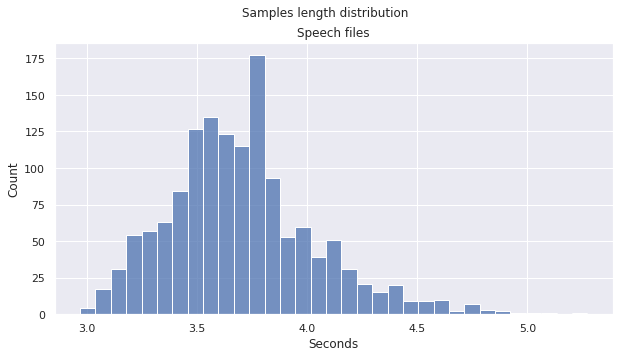

Max len of data samples:  116247.0


In [8]:
MAX_LEN = show_duration_distribution(speech_path, save_path, limit_per_actor=-1)
print("Max len of data samples: ", MAX_LEN)

## Preprocessing and feature extraction

The first step is to load all the files, padding them to a fixed size, once that is completed, the Feature Extractor obtain the features, an augmenter can be used to augment the data. For the initial visualization, identity is used as augmenter, with "classic" feature extraction.

In [9]:
loader = Loader(speech_path, save_path, True, int(MAX_LEN), -1)
data, labels = loader.load(False)

In [10]:
from src.data_processing import identity
orig_features, orig_labels = FeatureExtractor(raw_data=data, 
                                            labels=labels, 
                                            save_path=f"{save_path}/features", 
                                            file_name="classic",
                                            augmenter=identity, 
                                            verbose=True).get_training_data(overwrite=False)

Filename: classic found on disk



In [11]:
d = Dataset(original_data=(orig_features, orig_labels), augmented_data=[])
X_train, X_val, X_test, y_train, y_val, y_test = d.get_training_data(label="all", train_perc=0.5, val_perc=0.2)

## Classes distribution

The class distribution is the following, this implies that we need to deal with imbalanced classes during training.

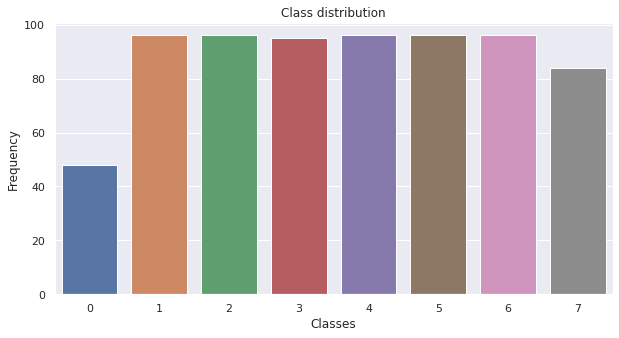

In [12]:
plot_classes(y_train)

## Data visualization
We extract the two features with most variance and plot the dataset.

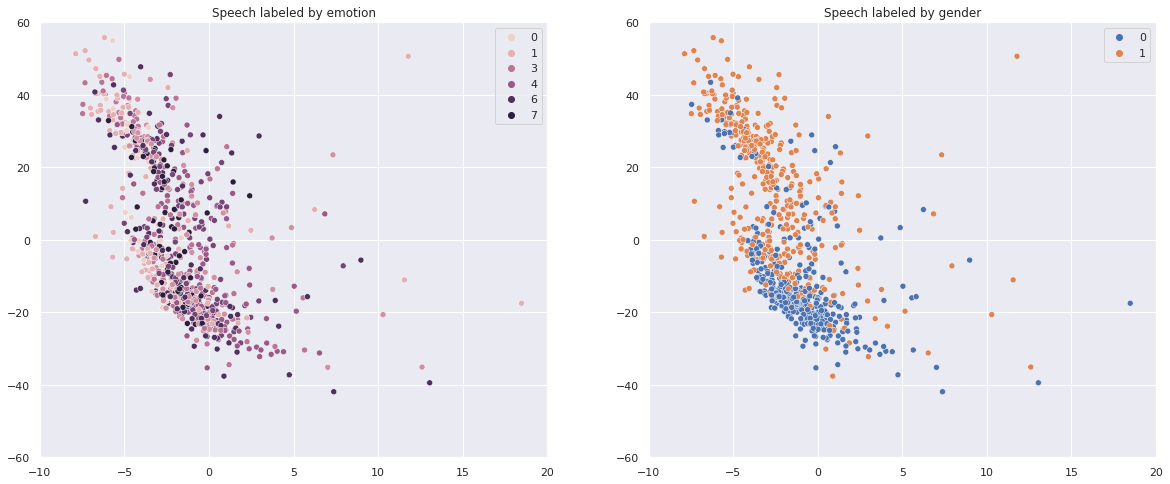

In [21]:
plot_clusters(Dataset(original_data=(orig_features, orig_labels), augmented_data=[]))

# Models training

After extracting features, the first part of the project consists in comparing the performance of Neural Networks, SVM and K-NN. They are tested on the emotion label.

## SVM training

In [ ]:
d = Dataset(original_data=(orig_features, orig_labels), augmented_data=[])
X_train, X_val, X_test, y_train, y_val, y_test = d.get_training_data(label="emotion", train_perc=0.5, val_perc=0.2, flatten=True)

from sklearn.svm import SVC

def build_train_svm(train, val, test):
  svm_model = SVC()
  svm_model.fit(train[0], train[1])
  print(f"SVM Accuracy on train: {svm_model.score(train[0], train[1])}")
  print(f"SVM Accuracy on validation:  {svm_model.score(val[0], val[1])}")
  print(f"SVM Accuracy on test:  {svm_model.score(test[0], test[1])}")

build_train_svm((X_train, y_train), (X_val, y_val), (X_test, y_test))

SVM Accuracy on train: 0.9306930693069307
SVM Accuracy on validation:  0.4612676056338028
SVM Accuracy on test:  0.47294117647058825


## KNN training
Here K is set to be sqrt of the number of training samples.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier as KNN

def build_train_knn(train, val, test):
  k = int(len(train[0])**(1/2))
  k += int((k%2)==0)

  knn_model = KNN(k)
  knn_model.fit(train[0], train[1])    
  print(f"{k}-NN Accuracy on train: {knn_model.score(train[0], train[1])}")
  print(f"{k}-NN Accuracy on validation:  {knn_model.score(val[0], val[1])}")
  print(f"{k}-NN Accuracy on test:  {knn_model.score(test[0], test[1])}")

build_train_knn((X_train, y_train), (X_val, y_val), (X_test, y_test))

27-NN Accuracy on train: 0.3620933521923621
27-NN Accuracy on validation:  0.2992957746478873
27-NN Accuracy on test:  0.25176470588235295


## Decision tree training

In [ ]:
from sklearn.tree import DecisionTreeClassifier

def build_train_tree(train, val, test):
  
  dtree = DecisionTreeClassifier(random_state=0, max_depth=10)
  dtree.fit(train[0], train[1])    
  print(f"Dtree Accuracy on train: {dtree.score(train[0], train[1])}")
  print(f"Dtree Accuracy on validation:  {dtree.score(val[0], val[1])}")
  print(f"Dtree Accuracy on test:  {dtree.score(test[0], test[1])}")

build_train_tree((X_train, y_train), (X_val, y_val), (X_test, y_test))

Dtree Accuracy on train: 0.9038189533239038
Dtree Accuracy on validation:  0.3204225352112676
Dtree Accuracy on test:  0.3129411764705882


## ANN and CNN training

In [ ]:
from sklearn.utils import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, LeakyReLU, Activation, Conv2D, Flatten, MaxPool2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import L1, L2, L1L2

from collections import Counter
import numpy as np

def class_weight(y):
    seq = y.copy().reshape(y.shape[0])
    t, L = len(np.unique(seq)), len(seq)
    return {k : L/(t*v) for k, v in Counter(seq).items()}

def build_nn(shape):
    model = Sequential()
    model.add(Input(shape=shape))
    model.add(Flatten())
    model.add(Dense(100, activation="relu", kernel_regularizer=L1L2(l1=1e-5, l2=1e-4), bias_regularizer=L2(1e-4), activity_regularizer=L2(1e-5)))
    model.add(Dropout(0.3))
    model.add(Dense(30, activation="relu", kernel_regularizer=L1L2(l1=1e-5, l2=1e-4), bias_regularizer=L2(1e-4), activity_regularizer=L2(1e-5)))
    model.add(Dropout(0.3))
    model.add(Dense(8, activation="softmax"))
    model.compile(optimizer='sgd', loss=SparseCategoricalCrossentropy(), metrics=["accuracy"])
    return model

def build_cnn(shape):
    inp = Input(shape=shape)
    x = Conv2D(32, (4,4), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Conv2D(32*2, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Conv2D(32*3, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Conv2D(32*3, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)

    x = Flatten()(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    out = Dense(8, activation="softmax")(x)
    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(), metrics=["accuracy"])
    return model

def train_nn(train_data, val_data, test_data, build_fun, epochs, verbose):
    
    m = build_fun(train_data[0][0].shape)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath="data/models/nn.hdf5",
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    w = class_weight(train_data[1])

    history = m.fit(train_data[0], train_data[1], validation_data=val_data, 
                        epochs=epochs, verbose=verbose, callbacks=[model_checkpoint_callback], class_weight=w)
    plot_history(history)
    
    m.load_weights("data/models/nn.hdf5")
    l, a = m.evaluate(test_data[0], test_data[1], verbose=0)
    print(f"TEST: Loss: {l}, accuracy: {a}")
    return m, history

Epoch 1/50
23/23 - 4s - loss: 2.8787 - accuracy: 0.1584 - val_loss: 2.3890 - val_accuracy: 0.2289 - 4s/epoch - 163ms/step
Epoch 2/50
23/23 - 0s - loss: 2.0358 - accuracy: 0.3083 - val_loss: 2.1695 - val_accuracy: 0.3063 - 129ms/epoch - 6ms/step
Epoch 3/50
23/23 - 0s - loss: 1.6271 - accuracy: 0.4441 - val_loss: 2.1097 - val_accuracy: 0.3486 - 132ms/epoch - 6ms/step
Epoch 4/50
23/23 - 0s - loss: 1.4245 - accuracy: 0.5276 - val_loss: 2.1250 - val_accuracy: 0.3944 - 128ms/epoch - 6ms/step
Epoch 5/50
23/23 - 0s - loss: 1.2871 - accuracy: 0.5672 - val_loss: 2.0757 - val_accuracy: 0.3979 - 131ms/epoch - 6ms/step
Epoch 6/50
23/23 - 0s - loss: 1.1375 - accuracy: 0.6464 - val_loss: 2.0505 - val_accuracy: 0.4120 - 135ms/epoch - 6ms/step
Epoch 7/50
23/23 - 0s - loss: 1.0515 - accuracy: 0.7001 - val_loss: 2.0295 - val_accuracy: 0.4296 - 134ms/epoch - 6ms/step
Epoch 8/50
23/23 - 0s - loss: 0.9073 - accuracy: 0.7383 - val_loss: 2.0415 - val_accuracy: 0.4296 - 125ms/epoch - 5ms/step
Epoch 9/50
23/23 

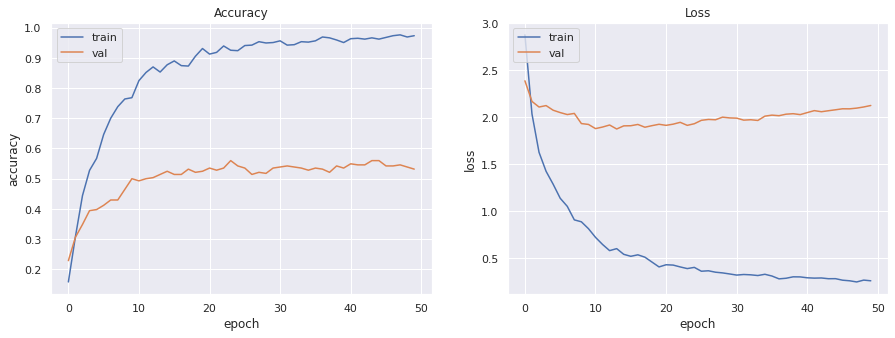

TEST: Loss: 2.0885987281799316, accuracy: 0.49176469445228577


In [ ]:
d = Dataset(original_data=(orig_features, orig_labels), augmented_data=[])
X_train, X_val, X_test, y_train, y_val, y_test = d.get_training_data(label="emotion", train_perc=0.5, val_perc=0.2)

model, history = train_nn((X_train, y_train), (X_val, y_val), (X_test, y_test), build_nn, epochs=50, verbose=2)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 9120)              0         
                                                                 
 dense (Dense)               (None, 100)               912100    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 30)                3030      
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 248       
                                                                 
Total params: 915,378
Trainable params: 915,378
Non-trai

Epoch 1/50
23/23 - 12s - loss: 1.8909 - accuracy: 0.3013 - val_loss: 4.5208 - val_accuracy: 0.2113 - 12s/epoch - 526ms/step
Epoch 2/50
23/23 - 1s - loss: 1.5177 - accuracy: 0.4625 - val_loss: 1.9020 - val_accuracy: 0.3099 - 648ms/epoch - 28ms/step
Epoch 3/50
23/23 - 1s - loss: 1.3774 - accuracy: 0.4965 - val_loss: 2.1205 - val_accuracy: 0.2430 - 684ms/epoch - 30ms/step
Epoch 4/50
23/23 - 1s - loss: 1.1569 - accuracy: 0.6096 - val_loss: 2.4549 - val_accuracy: 0.1937 - 684ms/epoch - 30ms/step
Epoch 5/50
23/23 - 1s - loss: 0.8973 - accuracy: 0.7016 - val_loss: 2.3652 - val_accuracy: 0.3239 - 652ms/epoch - 28ms/step
Epoch 6/50
23/23 - 1s - loss: 0.8104 - accuracy: 0.7313 - val_loss: 3.6165 - val_accuracy: 0.2042 - 625ms/epoch - 27ms/step
Epoch 7/50
23/23 - 1s - loss: 0.6683 - accuracy: 0.7680 - val_loss: 2.1495 - val_accuracy: 0.3556 - 648ms/epoch - 28ms/step
Epoch 8/50
23/23 - 1s - loss: 0.5271 - accuracy: 0.8670 - val_loss: 3.4114 - val_accuracy: 0.2570 - 692ms/epoch - 30ms/step
Epoch 9/

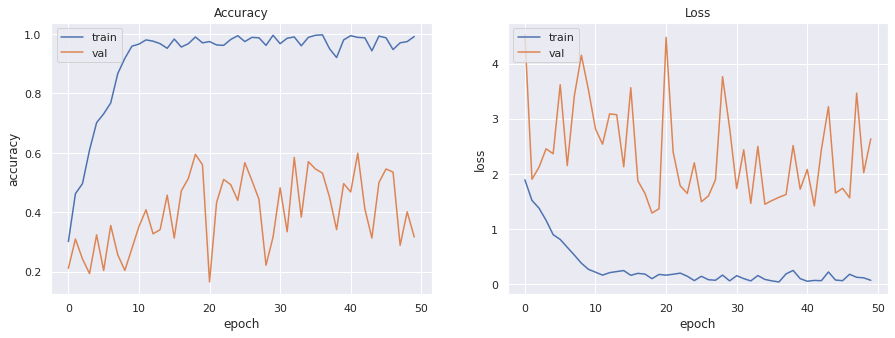

TEST: Loss: 1.4203996658325195, accuracy: 0.5694117546081543
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 40, 228, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 40, 228, 32)       544       
                                                                 
 batch_normalization (BatchN  (None, 40, 228, 32)      128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 40, 228, 32)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 114, 32)      0         
 )                                                               
                                                                 


In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = d.get_training_data(label="emotion", train_perc=0.5, val_perc=0.2)

def resp(x):
    return x.reshape(*x.shape, 1)

model, history = train_nn((resp(X_train), y_train), (resp(X_val), y_val), (resp(X_test), y_test), build_cnn, epochs=50, verbose=2)
model.summary()

## Results and data augmentation
Performance on test is quite poor, we now apply augmentation to the data, in the form of noise, speed and pitch and stretch.
The test data is obtained from the original dataset, while training and validation contains the augmented data.

In [ ]:
# parameters after path are not so important, as the raw data is precomputed
loader = Loader(speech_path, save_path, True, 0, -1)
data, labels = loader.load(False)
OVERWRITE = False

from src.data_processing import identity, noise, stretch, speedpitch

orig_features, orig_labels = FeatureExtractor(raw_data=data, labels=labels, save_path=f"{save_path}/features", file_name="classic", 
                                              augmenter=identity, verbose=True).get_training_data(overwrite=False)

noise_features, noise_labels = FeatureExtractor(raw_data=data, labels=labels, save_path=f"{save_path}/features", file_name="noise_classic", 
                                                augmenter=noise, verbose=True).get_training_data(overwrite=OVERWRITE)

stretch_features, stretch_labels = FeatureExtractor(raw_data=data, labels=labels, save_path=f"{save_path}/features", file_name="stretch_classic", 
                                                    augmenter=stretch, verbose=True).get_training_data(overwrite=OVERWRITE)

speed_features, speed_labels = FeatureExtractor(raw_data=data, labels=labels, save_path=f"{save_path}/features", file_name="speed_classic", 
                                                augmenter=speedpitch, verbose=True).get_training_data(overwrite=OVERWRITE)

original_data = (orig_features, orig_labels)
augmented_data = [(noise_features, noise_labels), (stretch_features, stretch_labels), (speed_features, speed_labels)]

d = Dataset(original_data=original_data, augmented_data=augmented_data)
X_train, X_val, X_test, y_train, y_val, y_test = d.get_training_data(label="emotion", train_perc=0.5, val_perc=0.2)

Filename: classic found on disk

Filename: noise_classic found on disk

Filename: stretch_classic found on disk

Filename: speed_classic found on disk



Epoch 1/50
89/89 - 1s - loss: 2.4923 - accuracy: 0.1787 - val_loss: 1.9981 - val_accuracy: 0.2921 - 1s/epoch - 13ms/step
Epoch 2/50
89/89 - 0s - loss: 1.8545 - accuracy: 0.3557 - val_loss: 1.8782 - val_accuracy: 0.3469 - 475ms/epoch - 5ms/step
Epoch 3/50
89/89 - 0s - loss: 1.6221 - accuracy: 0.4451 - val_loss: 1.7772 - val_accuracy: 0.4078 - 483ms/epoch - 5ms/step
Epoch 4/50
89/89 - 0s - loss: 1.3836 - accuracy: 0.5507 - val_loss: 1.7024 - val_accuracy: 0.4431 - 446ms/epoch - 5ms/step
Epoch 5/50
89/89 - 0s - loss: 1.2610 - accuracy: 0.5807 - val_loss: 1.6608 - val_accuracy: 0.4537 - 492ms/epoch - 6ms/step
Epoch 6/50
89/89 - 0s - loss: 1.1103 - accuracy: 0.6510 - val_loss: 1.6249 - val_accuracy: 0.4581 - 453ms/epoch - 5ms/step
Epoch 7/50
89/89 - 0s - loss: 1.0151 - accuracy: 0.6750 - val_loss: 1.6376 - val_accuracy: 0.4643 - 427ms/epoch - 5ms/step
Epoch 8/50
89/89 - 0s - loss: 0.9169 - accuracy: 0.7245 - val_loss: 1.6261 - val_accuracy: 0.4766 - 439ms/epoch - 5ms/step
Epoch 9/50
89/89 -

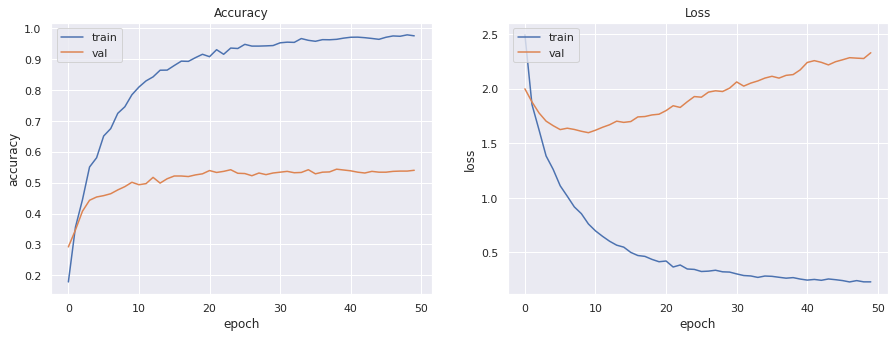

TEST: Loss: 2.4724769592285156, accuracy: 0.47058823704719543


In [ ]:
model, history = train_nn((X_train, y_train), (X_val, y_val), (X_test, y_test), build_nn, epochs=50, verbose=2)

Epoch 1/50
89/89 - 4s - loss: 1.9050 - accuracy: 0.2649 - val_loss: 2.0882 - val_accuracy: 0.1853 - 4s/epoch - 46ms/step
Epoch 2/50
89/89 - 3s - loss: 1.5258 - accuracy: 0.3939 - val_loss: 1.5614 - val_accuracy: 0.4051 - 3s/epoch - 28ms/step
Epoch 3/50
89/89 - 2s - loss: 1.2377 - accuracy: 0.5306 - val_loss: 1.6964 - val_accuracy: 0.3698 - 2s/epoch - 28ms/step
Epoch 4/50
89/89 - 3s - loss: 0.9956 - accuracy: 0.6390 - val_loss: 1.4998 - val_accuracy: 0.4625 - 3s/epoch - 28ms/step
Epoch 5/50
89/89 - 3s - loss: 0.7900 - accuracy: 0.7164 - val_loss: 1.3867 - val_accuracy: 0.5375 - 3s/epoch - 28ms/step
Epoch 6/50
89/89 - 3s - loss: 0.5733 - accuracy: 0.7972 - val_loss: 1.4947 - val_accuracy: 0.4360 - 3s/epoch - 28ms/step
Epoch 7/50
89/89 - 3s - loss: 0.4312 - accuracy: 0.8626 - val_loss: 1.3358 - val_accuracy: 0.5234 - 3s/epoch - 28ms/step
Epoch 8/50
89/89 - 3s - loss: 0.2913 - accuracy: 0.9120 - val_loss: 1.5656 - val_accuracy: 0.5393 - 3s/epoch - 29ms/step
Epoch 9/50
89/89 - 3s - loss: 0.

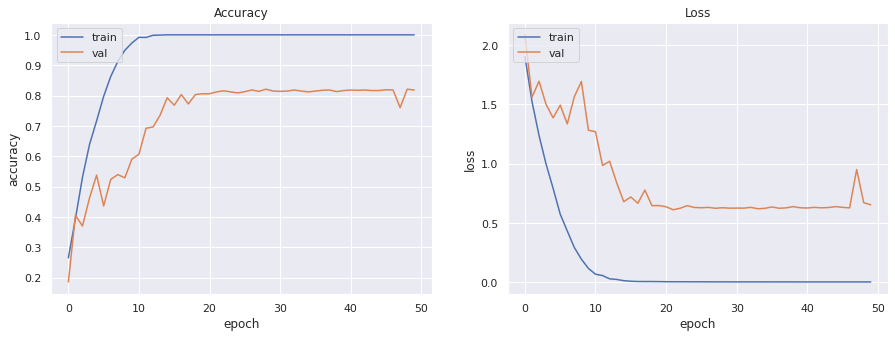

TEST: Loss: 1.1297938823699951, accuracy: 0.6988235116004944


In [ ]:
model, history = train_nn((resp(X_train), y_train), (resp(X_val), y_val), (resp(X_test), y_test), build_cnn, epochs=50, verbose=2)

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = d.get_training_data(label="emotion", train_perc=0.5, val_perc=0.2, flatten=True)
build_train_svm((X_train, y_train), (X_val, y_val), (X_test, y_test))
print()
build_train_knn((X_train, y_train), (X_val, y_val), (X_test, y_test))
print()
build_train_tree((X_train, y_train), (X_val, y_val), (X_test, y_test))

SVM Accuracy on train: 0.9321794418933239
SVM Accuracy on validation:  0.4960282436010591
SVM Accuracy on test:  0.4894117647058824

53-NN Accuracy on train: 0.24690921935711763
53-NN Accuracy on validation:  0.21977052074139453
53-NN Accuracy on test:  0.20941176470588235

Dtree Accuracy on train: 0.6231013776050865
Dtree Accuracy on validation:  0.264783759929391
Dtree Accuracy on test:  0.25882352941176473


Performance increase among all models

## Auto encoders

We now try to perform some pre-training with auto-encoders to see if performance increases. They are trained with only the augmented train split. 

Epoch 1/10
89/89 - 1s - loss: 1.0680 - val_loss: 0.8604 - 796ms/epoch - 9ms/step
Epoch 2/10
89/89 - 0s - loss: 0.7359 - val_loss: 0.6460 - 193ms/epoch - 2ms/step
Epoch 3/10
89/89 - 0s - loss: 0.5715 - val_loss: 0.5306 - 210ms/epoch - 2ms/step
Epoch 4/10
89/89 - 0s - loss: 0.4788 - val_loss: 0.4584 - 217ms/epoch - 2ms/step
Epoch 5/10
89/89 - 0s - loss: 0.4159 - val_loss: 0.4061 - 204ms/epoch - 2ms/step
Epoch 6/10
89/89 - 0s - loss: 0.3695 - val_loss: 0.3660 - 188ms/epoch - 2ms/step
Epoch 7/10
89/89 - 0s - loss: 0.3348 - val_loss: 0.3369 - 246ms/epoch - 3ms/step
Epoch 8/10
89/89 - 0s - loss: 0.3080 - val_loss: 0.3127 - 195ms/epoch - 2ms/step
Epoch 9/10
89/89 - 0s - loss: 0.2862 - val_loss: 0.2923 - 209ms/epoch - 2ms/step
Epoch 10/10
89/89 - 0s - loss: 0.2682 - val_loss: 0.2750 - 189ms/epoch - 2ms/step


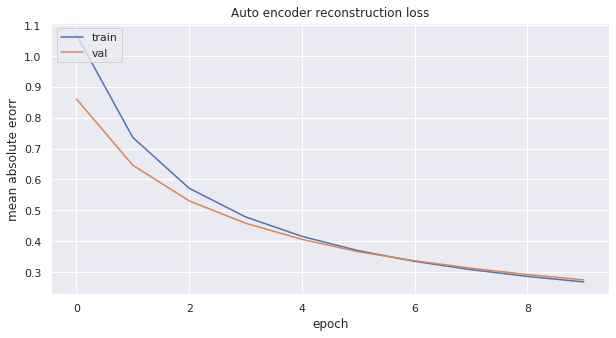

In [ ]:
# N = 50
# n_bottleneck = N//2

# # encoder
# visible = Input(shape=X_train[0].shape)
# # e = Dense(n_mid, activation="relu", kernel_regularizer=L1L2(l1=1e-5, l2=1e-4), bias_regularizer=L2(1e-4), activity_regularizer=L2(1e-5))(visible)
# # bottleneck
# bottleneck = Dense(n_bottleneck, activation="relu", kernel_regularizer=L1L2(l1=1e-5, l2=1e-4), bias_regularizer=L2(1e-4), activity_regularizer=L2(1e-5))(visible)
# # # decoder
# # d = Dense(n_mid, activation="relu", kernel_regularizer=L1L2(l1=1e-5, l2=1e-4), bias_regularizer=L2(1e-4), activity_regularizer=L2(1e-5))(bottleneck)
# # output
# output = Dense(N, activation='linear')(bottleneck)
# model = Model(inputs=visible, outputs=output)
# model.compile(optimizer='adam', loss='mse')

# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath="data/models/autoenc.hdf5",
#     save_weights_only=True,
#     monitor='val_loss',
#     mode='min',
#     save_best_only=True)

# history = model.fit(X_train, X_train, epochs=100, verbose=0, validation_data=(X_val,X_val), callbacks=[model_checkpoint_callback])
# model.load_weights("data/models/autoenc.hdf5")
# plot_encoder_loss(history)

# # get encoder from input to bottleneck
# encoder = Model(inputs=visible, outputs=bottleneck)

# X_train_encode = encoder.predict(X_train)
# X_val_encode = encoder.predict(X_val)
# X_test_encode = encoder.predict(X_test)

# from sklearn.preprocessing import StandardScaler
# s = StandardScaler()
# s.fit(X_train_encode)
# X_train_encode = s.transform(X_train_encode)
# X_val_encode = s.transform(X_val_encode)
# X_test_encode = s.transform(X_test_encode)

In [ ]:
# build_train_svm((X_train_encode, y_train), (X_val_encode, y_val), (X_test_encode, y_test))
# print()
# build_train_knn((X_train_encode, y_train), (X_val_encode, y_val), (X_test_encode, y_test))
# print()
# build_train_tree((X_train_encode, y_train), (X_val_encode, y_val), (X_test_encode, y_test))

SVM Accuracy on train: 0.6213352172377252
SVM Accuracy on validation:  0.4624889673433363
SVM Accuracy on test:  0.4211764705882353

53-NN Accuracy on train: 0.3825503355704698
53-NN Accuracy on validation:  0.3159752868490733
53-NN Accuracy on test:  0.30823529411764705

Dtree Accuracy on train: 0.8583539385376192
Dtree Accuracy on validation:  0.3089143865842895
Dtree Accuracy on test:  0.26823529411764707


Epoch 1/10
89/89 - 1s - loss: 2.3932 - accuracy: 0.1049 - val_loss: 2.3435 - val_accuracy: 0.1156 - 869ms/epoch - 10ms/step
Epoch 2/10
89/89 - 0s - loss: 2.2332 - accuracy: 0.1282 - val_loss: 2.2226 - val_accuracy: 0.1333 - 205ms/epoch - 2ms/step
Epoch 3/10
89/89 - 0s - loss: 2.1521 - accuracy: 0.1498 - val_loss: 2.1539 - val_accuracy: 0.1615 - 195ms/epoch - 2ms/step
Epoch 4/10
89/89 - 0s - loss: 2.1015 - accuracy: 0.1646 - val_loss: 2.1085 - val_accuracy: 0.1748 - 183ms/epoch - 2ms/step
Epoch 5/10
89/89 - 0s - loss: 2.0656 - accuracy: 0.1738 - val_loss: 2.0753 - val_accuracy: 0.1774 - 192ms/epoch - 2ms/step
Epoch 6/10
89/89 - 0s - loss: 2.0376 - accuracy: 0.1883 - val_loss: 2.0488 - val_accuracy: 0.1906 - 192ms/epoch - 2ms/step
Epoch 7/10
89/89 - 0s - loss: 2.0136 - accuracy: 0.1985 - val_loss: 2.0259 - val_accuracy: 0.1995 - 183ms/epoch - 2ms/step
Epoch 8/10
89/89 - 0s - loss: 1.9924 - accuracy: 0.2091 - val_loss: 2.0051 - val_accuracy: 0.2101 - 171ms/epoch - 2ms/step
Epoch 9/10
89/8

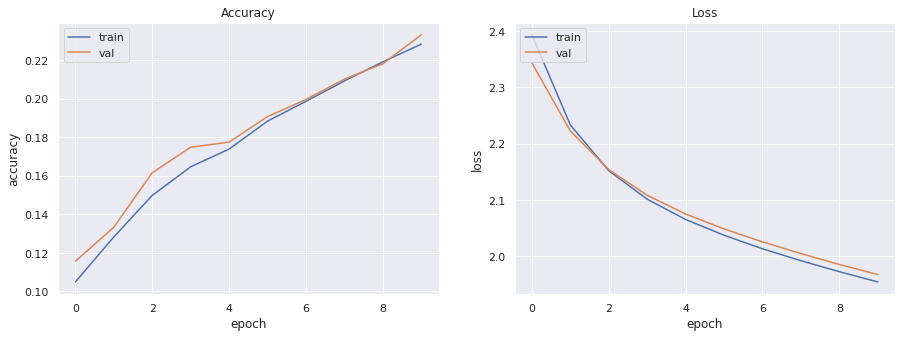

TEST: Loss: 1.9178929328918457, accuracy: 0.25882354378700256
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_55 (Dense)            (None, 12)                312       
                                                                 
 dense_56 (Dense)            (None, 8)                 104       
                                                                 
Total params: 416
Trainable params: 416
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# def build_nn_enc(shape):
#     model = Sequential()
#     model.add(Input(shape=X_train_encode[0].shape))
#     model.add(Dense(12, activation="relu", kernel_regularizer=L1L2(l1=1e-5, l2=1e-4), bias_regularizer=L2(1e-4), activity_regularizer=L2(1e-5)))
#     model.add(Dense(8, activation="softmax"))
#     model.compile(optimizer='sgd', loss=SparseCategoricalCrossentropy(), metrics=["accuracy"])
#     return model

# model, history = train_nn((X_train_encode, y_train), (X_val_encode, y_val), (X_test_encode, y_test), build_nn_enc, epochs=50, verbose=2)
# model.summary()